In [84]:
import pandas as pd
import numpy as np

In [4]:
eventos = pd.read_json("../../simulation.jsonlines", lines=True)
planes = pd.read_json("../../plans.jsonlines", lines=True)

# Recuentos básicos

In [11]:
# ¿Cuántos camiones hay?
print("Camiones: ", eventos["truckId"].nunique())
# ¿Cuántas localizaciones hay?
paquetes = pd.concat([pd.DataFrame(x) for x in planes["items"]])
print("Localizaciones: ", paquetes["locationId"].nunique())
# ¿Cuántos viajes hay? Interpretando que un viaje es la ruta de un camión en una simulación
print("Viajes: ", len(eventos.groupby(["truckId", "simulationId"])))
# ¿Cuántas simulaciones hay?
print("Simulaciones: ", eventos["simulationId"].nunique())


Camiones:  20
Localizaciones:  2030
Viajes:  625
Simulaciones:  100


### Tiempos de viaje

Según el plan de entrega, considerando que un viaje es el desplazamiento entre dos localizaciones

In [13]:
viajes = []
for truck_list in planes["trucks"]:
    for truck in truck_list:
        viajes.append(pd.DataFrame(truck["route"]))
viajes = pd.concat(viajes)
viajes.duration.describe()

count    4059.000000
mean      835.669130
std       830.597292
min         0.000000
25%       302.500000
50%       557.000000
75%      1016.500000
max      5442.000000
Name: duration, dtype: float64

In [14]:
# filtramos los viajes que no tienen duración
viajes[viajes.duration > 0].duration.describe()

count    4051.000000
mean      837.319427
std       830.585603
min        24.000000
25%       304.000000
50%       557.000000
75%      1017.000000
max      5442.000000
Name: duration, dtype: float64

### Tiempos de entrega

Se calculan como la diferencia entre los eventTime de los eventos "Truck started delivering" y "Truck ended delivering"

In [19]:
# Ordenamos los eventos por simulación, camión y tiempo
eventos = eventos.sort_values(["simulationId", "truckId", "eventTime"])
# filtramos para quedarnos con los eventos que nos interesan
entregas = eventos[eventos.eventType.isin(["Truck started delivering", "Truck ended delivering"])]
# restamos a cada fila el tiempo del evento anterior y luego nos quedamos solo con los eventos de fin de entrega
entregas = entregas.assign(delta=entregas.eventTime - entregas.eventTime.shift(1)).loc[entregas.eventType == "Truck ended delivering"]
entregas.delta.describe()

count      8575.000000
mean      89751.167347
std       30278.171637
min           0.000000
25%       60200.000000
50%       60310.000000
75%      120200.000000
max      121920.000000
Name: delta, dtype: float64

In [20]:
# filtramos las entregas que no tienen duración
entregas[entregas.delta > 0].delta.describe()

count      8555.000000
mean      89960.988895
std       30000.553329
min       60020.000000
25%       60200.000000
50%       60320.000000
75%      120200.000000
max      121920.000000
Name: delta, dtype: float64

<AxesSubplot:ylabel='Frequency'>

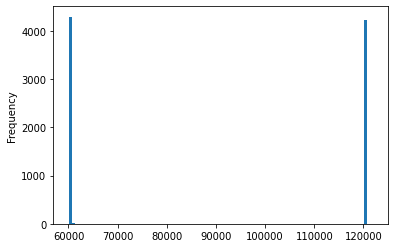

In [26]:
# en una gráfica
entregas[entregas.delta > 0].delta.plot.hist(bins=100)

### Agrupaciones

In [43]:
# Número de paquetes por cada camión. Considerando en cada simulación
camiones = []
for simId in planes.simulationId.unique():
    for truck in planes[planes.simulationId == simId].trucks.values[0]:
        camiones.append(pd.DataFrame(truck["route"]).assign(simulationId=simId, truckId=truck["truck_id"]))
camiones = pd.concat(camiones)
camiones.groupby(["simulationId", "truckId"]).size().describe()


count    625.000000
mean       6.494400
std        3.268495
min        2.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       15.000000
dtype: float64

In [44]:
# Número de paquetes por cada simulación
planes["items"].apply(len).describe()

count    100.000000
mean      85.790000
std        9.651812
min       68.000000
25%       78.000000
50%       86.500000
75%       93.000000
max      106.000000
Name: items, dtype: float64

## Preguntas sencillas

Las localizaciones más visitadas, con  6  visitas, son:  ['1fc942f4744ab3ea3b8d1009' '7e975a3a8ac9b661a5eeb963'
 'faf06210580833f8c7963506' '27dd57ad86f32b35c0eaf1cc'
 '49177b9a644f14dcbbdc32c1' '794ef428d858678e69ec18f4']
Las localizaciones con más paquetes recibidos son:
794ef428d858678e69ec18f4    18
8ffce61f79bacefe2a6b5f16    18
e8b12df2ab69d3300dfd0434    17
ce6feed06bc1a9e5aff95f04    16
c61593b7ca2c3037053cd317    16
3d7e64824d4d3abb200b3c1b    16
90a34d33b273c9c35b709734    16
c8d0b848c426f58c5e525448    15
544dc8cb8104ca9be64e088e    15
87dba784e93d5a2519b2498b    15
Name: items, dtype: int64
Los camiones con más paquetes transportados son:
truckId
3321FBL    793
5534TPH    785
3953RLD    633
5030LXK    422
6270NFM    380
0013DYS    270
9593DXM    181
8386WZB    177
6965XLY    135
0781PZL    106
dtype: int64
Distribución del número de eventos de cada tipo
AxesSubplot(0.125,0.125;0.775x0.755)


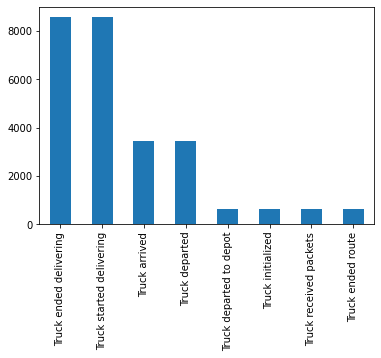

In [100]:
# Localización más visitada. Considero la localización que más veces se ha visitado en diferentes simulaciones
loc_counts = planes["items"].apply(lambda x: set([l["locationId"] for l in x])).explode().value_counts()
print("Las localizaciones más visitadas, con ",loc_counts.values[0], " visitas, son: ", loc_counts.where(loc_counts == loc_counts.values[0]).dropna().index.values)

# Número de paquetes recibidos por cada localización
loc_counts = planes["items"].apply(lambda x: [l["locationId"] for l in x]).explode().value_counts()
print("Las localizaciones con más paquetes recibidos son:")
print(loc_counts.head(10))

# Número de paquetes transportados en total en cada camión
print("Los camiones con más paquetes transportados son:")
print(camiones.groupby(["truckId"]).size().sort_values(ascending=False).head(10))

# Número de localizaciones distintas que ha visitado cada camión
print("Número de localizaciones distintas que ha visitado cada camión:")
print(camiones.groupby(["truckId"])["destination"].nunique())

# Distribución del número de eventos de cada tipo
print("Distribución del número de eventos de cada tipo")
print(eventos.eventType.value_counts().plot.bar())

# Número de paquetes que lleva cada camión en cada viaje (ya calculada en la sección anterior)

## Preguntas medias

In [ ]:
eventos = eventos.sort_values(["simulationId", "truckId", "eventTime"])
eventos["prev_event"] = eventos.groupby(["truckId", "simulationId"])["eventType"].shift(1)
eventos["prev_time"] = eventos.groupby(["truckId", "simulationId"])["eventTime"].shift(1)
eventos["delta"] = eventos.eventTime - eventos.prev_time

In [98]:
# La localización que más camiones (distintos) han visitado
loc = camiones.groupby(["truckId"])["destination"].unique().explode().value_counts()
print("La localización que más camiones distintos (",loc.values[0] ,") han visitado es: ", loc.index[0])

# Tiempo de viaje máximo, mínimo y medio. Según los eventos de inicio y fin de viaje
print("Tiempos de viaje: ")
print(eventos[eventos.eventType.isin(["Truck arrived", "Truck ended route"])].delta.describe())

# Tiempo de entrega máximo, mínimo y medio (ya calculado en la primera sección)

# Nº de horas que cada camión ha estado activo
print("Horas que cada camión ha estado activo: ")
print(eventos.groupby(["truckId", "simulationId"]).eventTime.max().reset_index().groupby("truckId")["eventTime"].sum()/3600000)
# Cuántas de viaje
print("De las cuales en viaje: ")
print(eventos[eventos.eventType.isin(["Truck arrived", "Truck ended route"])].groupby("truckId").delta.sum()/3600000)
# Cuántas en total (contando tiempos de entrega)
print("Y entregando paquetes: ")
print(entregas.groupby("truckId").delta.sum()/3600000)


# Diferencia de tiempos entre un evento y el siguiente (de la misma simulación y mismo camión)
print("Diferencia de tiempos entre un evento y el siguiente:")
print(eventos.delta.describe())
# Agregar por tipo de evento “origen” y “destino”
print("Agregando por tipo de evento origen y destino:")
print(eventos.groupby(["prev_event", "eventType"]).delta.describe())



La localización que más camiones distintos ( 20 ) han visitado es:  ce6feed06bc1a9e5aff95f04
Tiempos de viaje: 
count    4.057000e+03
mean     8.322312e+05
std      8.309798e+05
min      0.000000e+00
25%      3.006600e+05
50%      5.541500e+05
75%      1.008570e+06
max      5.442690e+06
Name: delta, dtype: float64
Horas que cada camión ha estado activo: 
truckId
0013DYS     80.780347
0184WLX      1.500631
0265TYL     14.990372
0781PZL     32.959181
1012GWV      1.760936
1161GJN      2.662236
1316CKM      1.256867
1489WHW      1.740886
1669HSZ     10.944992
2423VRT     22.995414
3321FBL    173.650892
3953RLD    166.708517
5030LXK    131.983269
5534TPH    188.514756
6270NFM     95.850156
6965XLY     45.687553
8327DZH      1.619886
8386WZB     91.684258
8809GPH      3.635175
9593DXM     86.500686
Name: eventTime, dtype: float64
De las cuales en viaje: 
truckId
0013DYS     67.629875
0184WLX      1.466956
0265TYL     13.232144
0781PZL     27.637636
1012GWV      1.677231
1161GJN      2.36015

# Preguntas Avanzadas

In [112]:
tiempos_plan = camiones.sort_values(["simulationId","truckId"]).assign(duration=lambda x: x["duration"]*1000).groupby(["simulationId","truckId"]).duration.agg(list).reset_index()
tiempos_plan.rename(columns={"duration":"tiempo_plan"}, inplace=True)
tiempos_plan

,simulationId,truckId,tiempo_plan
0,00ab3765-2a12-425d-a12a-07577a572829,0013DYS,"[502000, 730000, 259000, 548000, 272000, 1660000]"
1,00ab3765-2a12-425d-a12a-07577a572829,3321FBL,"[154000, 405000, 379000, 758000, 85000, 422000..."
2,00ab3765-2a12-425d-a12a-07577a572829,3953RLD,"[486000, 1678000, 722000, 1684000]"
3,00ab3765-2a12-425d-a12a-07577a572829,5534TPH,"[534000, 366000, 147000, 552000, 51000, 777000..."
4,00ab3765-2a12-425d-a12a-07577a572829,6270NFM,"[1307000, 1377000, 1900000]"
...,...,...,...
620,fd4bc7cb-f234-4653-a87d-2514d6df6eca,3953RLD,"[154000, 4097000, 3829000, 511000]"
621,fd4bc7cb-f234-4653-a87d-2514d6df6eca,5030LXK,"[714000, 322000, 223000, 877000, 890000, 10100..."
622,fd4bc7cb-f234-4653-a87d-2514d6df6eca,5534TPH,"[1327000, 77000, 418000, 215000, 237000, 58100..."
623,fd4bc7cb-f234-4653-a87d-2514d6df6eca,6270NFM,"[772000, 169000, 124000, 190000, 198000, 28800..."


In [113]:
tiempos_sim = eventos[eventos.eventType.isin(["Truck arrived", "Truck ended route"])].sort_values(["simulationId","truckId", "eventTime"]).groupby(["simulationId","truckId"]).delta.agg(list).reset_index()
tiempos_sim.rename(columns={"delta":"tiempo_sim"}, inplace=True)
tiempos_sim

,simulationId,truckId,tiempo_sim
0,00ab3765-2a12-425d-a12a-07577a572829,0013DYS,"[502180.0, 730650.0, 259140.0, 548940.0, 27281..."
1,00ab3765-2a12-425d-a12a-07577a572829,3321FBL,"[154980.0, 405820.0, 379110.0, 758550.0, 85260..."
2,00ab3765-2a12-425d-a12a-07577a572829,3953RLD,"[486100.0, 1678300.0, 722340.0, 1684850.0]"
3,00ab3765-2a12-425d-a12a-07577a572829,5534TPH,"[534930.0, 366310.0, 147260.0, 552830.0, 51980..."
4,00ab3765-2a12-425d-a12a-07577a572829,6270NFM,"[1308010.0, 1377610.0, 1901050.0]"
...,...,...,...
619,fd4bc7cb-f234-4653-a87d-2514d6df6eca,3953RLD,"[154990.0, 4097980.0, 3830120.0, 511620.0]"
620,fd4bc7cb-f234-4653-a87d-2514d6df6eca,5030LXK,"[715090.0, 322930.0, 223260.0, 877610.0, 89063..."
621,fd4bc7cb-f234-4653-a87d-2514d6df6eca,5534TPH,"[1327170.0, 77850.0, 418140.0, 215750.0, 23805..."
622,fd4bc7cb-f234-4653-a87d-2514d6df6eca,6270NFM,"[772130.0, 169930.0, 124920.0, 191040.0, 19905..."


In [121]:
retrasos = tiempos_sim.merge(tiempos_plan, on=["simulationId","truckId"]).dropna().reset_index(drop=True)

In [137]:
retrasos["retraso"] = retrasos.apply(lambda x: np.array(x.tiempo_sim)-np.array(x.tiempo_plan), axis=1)


In [151]:
valores_retraso = retrasos.explode("retraso").reset_index(drop=True)
valores_retraso.retraso.apply(lambda x: x/1000).describe()

count    4057.000000
mean       -3.849860
std        82.432945
min     -2993.000000
25%         0.350000
50%         0.610000
75%         0.850000
max         2.320000
Name: retraso, dtype: float64